In [1]:
import joblib
from sklearn.preprocessing import StandardScaler , MinMaxScaler, RobustScaler
from sklearn.model_selection import LeaveOneOut
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# from envs.filtr_json_from_race import load_from_db
import sqlite3
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold

from config import X_SHAPE, Y_SHAPE, CONT_LENGTH, CAT_LENGTH
import gc


In [2]:
from config import X_SHAPE, Y_SHAPE, CONT_LENGTH, CAT_LENGTH, Y_INDEXES, NO_SCALER_IDXES_X, MIN_MAX_SCALER_IDXES_X, ROBUST_SCALER_IDXES_X, NO_SCALER_IDEXES_Y, MIN_MAX_SCALER_IDXES_Y, ROBUST_SCALER_IDXES_Y



class LSTMStatePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1,dropout_prob=0.3):
        super(LSTMStatePredictor, self).__init__()
        
        # Zapisz parametry (potrzebne do ewentualnego ręcznego
        # tworzenia stanu, choć nie jest to już wymagane w forward)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        lstm_dropout_prob = dropout_prob if num_layers > 1 else 0.0
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,dropout=lstm_dropout_prob)

        self.dropout_layer = nn.Dropout(dropout_prob)
        self.act_delta = nn.ReLU()
    
      
        self.heads = nn.ModuleList([
            nn.Linear(hidden_size, 2),  # progress
            nn.Linear(hidden_size, 1),  # fuel
            nn.Linear(hidden_size, 4),  # wear
            nn.Linear(hidden_size, 4) # temp
            # nn.Linear(hidden_size, 1)   # track wetness
        ])

      
        self.output_size = output_size

    def forward(self, x, h_c=None):
        # 1. Nie musisz ręcznie inicjować h_c. 
        #    nn.LSTM zrobi to automatycznie, jeśli h_c jest None.
        
        # 2. Przetwórz CAŁĄ sekwencję
        #    x ma kształt: [B, seq_len, 37]
        #    out będzie miał kształt: [B, seq_len, hidden_size]
        out, h_c = self.lstm(x, h_c) 

        out = self.dropout_layer(out)  # Zastosuj dropout do wyjścia LSTM
        
        # 3. Zastosuj głowice do CAŁEGO tensora 'out', a nie tylko 'out[:, -1, :]'
        #    head(out) da np. [B, seq_len, 2]
        outputs = [head(out) for head in self.heads]

        outputs[2] = self.act_delta(outputs[2])


        
        # 4. Połącz wzdłuż ostatniego wymiaru (wymiaru cech)
        #    List of [B,S,2], [B,S,1], [B,S,4]... -> [B, S, 12]
        #    Używamy dim=2, ponieważ kształt to (Batch, Seq_len, Features)
        combined = torch.cat(outputs, dim=2) 
        
        return combined, h_c

def create_scalers(X,Y):

    # cont_indices_x = slice(0, CONT_LENGTH)   # continuous columns for X (0–18)
    # cont_indices_y = slice(0, Y_SHAPE)   # continuous columns for Y (0–11)

    no_scaler_x = slice(0, NO_SCALER_IDXES_X)  # no scaler for X
    min_max_scaler_x = slice(NO_SCALER_IDXES_X, MIN_MAX_SCALER_IDXES_X)  # min-max scaler for X
    robust_scaler_x = slice(MIN_MAX_SCALER_IDXES_X, ROBUST_SCALER_IDXES_X)  # robust scaler for X
    no_scaler_y = slice(0, NO_SCALER_IDEXES_Y)  # no scaler for Y
    min_max_scaler_y = slice(NO_SCALER_IDEXES_Y, MIN_MAX_SCALER_IDXES_Y)  # min-max scaler for Y
    robust_scaler_y = slice(MIN_MAX_SCALER_IDXES_Y, ROBUST_SCALER_IDXES_Y)  # robust scaler for Y

   
    flat_x_min_max = np.vstack([x[:, min_max_scaler_x] for x in X])
    flat_x_robust = np.vstack([x[:, robust_scaler_x] for x in X])
    flat_y_min_max = np.vstack([y[:, min_max_scaler_y] for y in Y])
    flat_y_robust = np.vstack([y[:, robust_scaler_y] for y in Y])

    scaler_X_min_max = MinMaxScaler().fit(flat_x_min_max)
    scaler_X_robust = RobustScaler().fit(flat_x_robust)
    scaler_Y_min_max = MinMaxScaler().fit(flat_y_min_max)
    scaler_Y_robust = RobustScaler().fit(flat_y_robust)

   
    return scaler_X_min_max, scaler_X_robust, scaler_Y_min_max, scaler_Y_robust

def scale_input(X, Y, scaler_X_min_max, scaler_X_robust, scaler_Y_min_max, scaler_Y_robust):
    no_scaler_x = slice(0, NO_SCALER_IDXES_X)  # no scaler for X
    min_max_scaler_x = slice(NO_SCALER_IDXES_X, MIN_MAX_SCALER_IDXES_X)  # min-max scaler for X
    robust_scaler_x = slice(MIN_MAX_SCALER_IDXES_X, ROBUST_SCALER_IDXES_X)  # robust scaler for X
    no_scaler_y = slice(0, NO_SCALER_IDEXES_Y)  # no scaler for Y
    min_max_scaler_y = slice(NO_SCALER_IDEXES_Y, MIN_MAX_SCALER_IDXES_Y)  # min-max scaler for Y
    robust_scaler_y = slice(MIN_MAX_SCALER_IDXES_Y, ROBUST_SCALER_IDXES_Y)  # robust scaler for Y

    X_scaled_grouped = []
    Y_scaled_grouped = []

    for x_seq, y_seq in zip(X, Y):
        x_scaled = np.array(x_seq, dtype=float)
        x_scaled[:, min_max_scaler_x] = scaler_X_min_max.transform(x_seq[:, min_max_scaler_x])
        x_scaled[:, robust_scaler_x] = scaler_X_robust.transform(x_seq[:, robust_scaler_x])
        X_scaled_grouped.append(x_scaled)

        y_scaled = np.array(y_seq, dtype=float)
        y_scaled[:, min_max_scaler_y] = scaler_Y_min_max.transform(y_seq[:, min_max_scaler_y])
        y_scaled[:, robust_scaler_y] = scaler_Y_robust.transform(y_seq[:, robust_scaler_y])
        Y_scaled_grouped.append(y_scaled)

    # Conversion to torch tensors
    # X_t = [torch.tensor(x, dtype=torch.float32) for x in X_scaled_grouped]
    # Y_cont_t = [torch.tensor(y[:, cont_indices_y], dtype=torch.float32) for y in Y_scaled_grouped]

    return X_scaled_grouped, Y_scaled_grouped

# def scale_single_input(x, scaler_X):
#     cont_indices_x = slice(0, 19)   # continuous columns for X
#     X_scaled_grouped = []

#     for x_seq in x:
#         x_scaled = np.array(x_seq, dtype=float)
#         x_scaled[:, cont_indices_x] = scaler_X.transform(x_seq[:, cont_indices_x])
#         X_scaled_grouped.append(x_scaled)
#     return X_scaled_grouped

def scale_single_input(raw_vector_x, scaler_X_min_max, scaler_X_robust):
    """
    Skaluje pojedynczy wektor (37,), stosując scaler tylko do 
    części ciągłej (0-19) i zostawiając kategorialną (20-36).
    """
    no_scaler_x = slice(0, NO_SCALER_IDXES_X)  # no scaler for X
    min_max_scaler_x = slice(NO_SCALER_IDXES_X, MIN_MAX_SCALER_IDXES_X)  # min-max scaler for X
    robust_scaler_x = slice(MIN_MAX_SCALER_IDXES_X, ROBUST_SCALER_IDXES_X)  # robust scaler for X
 
    
    # raw_vector_x[cont_indices_x] ma kształt (19,)
    # Musimy go przekształcić na (1, 19) dla scalera
    x_min_max_scaled = scaler_X_min_max.transform([raw_vector_x[min_max_scaler_x]])
    x_robust_scaled = scaler_X_robust.transform([raw_vector_x[robust_scaler_x]])
    
    # raw_vector_x[cat_indices_x] ma kształt (18,)
    # --- POPRAWKA TUTAJ ---
    # Musimy go przekształcić na (1, 19), aby pasował do hstack
    x_no_scaled = raw_vector_x[no_scaler_x].reshape(1, -1)
    
    # Teraz łączymy (1, 19) z (1, 18) -> (1, 37)
    # i spłaszczamy z powrotem do 1D (37,)
    return np.hstack([x_no_scaled, x_min_max_scaled, x_robust_scaled]).flatten()
       

# def create_window_pred(sequence_x, window_size, n_steps_ahead=5):
#     X, Y = [], []
#     sequence_x = np.array(sequence_x)
#     curr_len = len(sequence_x)

#     start = max(0, curr_len - window_size)
#     window = sequence_x[start:curr_len]

#     pad_len = window_size - len(window)
#     if pad_len > 0:
#         window = np.vstack([np.zeros((pad_len, sequence_x.shape[1])), window])

#     # dodaj batch dimension
#     X = window[np.newaxis, :, :]  # shape [1, window_size, num_features]
#     return X



def generate_predictions(model, input_seq,scaler_X_min_max=None, scaler_X_robust=None, scaler_Y_min_max=None, scaler_Y_robust=None,h_c=None):
    no_scaler_y = slice(0, NO_SCALER_IDEXES_Y)  # no scaler for Y
    min_max_scaler_y = slice(NO_SCALER_IDEXES_Y, MIN_MAX_SCALER_IDXES_Y)  # min-max scaler for Y
    robust_scaler_y = slice(MIN_MAX_SCALER_IDXES_Y, ROBUST_SCALER_IDXES_Y)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    lap_dist_sin = np.sin(2 * np.pi * input_seq[0])

    lap_dist_cos = np.cos(2 * np.pi * input_seq[0])
    # input_seq = create_window_pred(input_seq, window_size=30, n_steps_ahead=n_steps_ahead)
    input_seq = np.hstack([
        lap_dist_sin, 
        lap_dist_cos, 
        input_seq[1:]  # <-- Pomijamy starą cechę LAP_DIST
    ])
    input_seq = scale_single_input(input_seq, scaler_X_min_max, scaler_X_robust)



    
         
    with torch.no_grad():
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).reshape(1, 1, X_SHAPE).to(device)
        predictions , h_c = model(input_tensor, h_c)
        predictions_scaled = predictions.cpu().numpy().reshape(1, Y_SHAPE)

        predictions_raw = np.zeros_like(predictions_scaled)
        
        # A. No Scaler (Sin/Cos) - Przepisujemy
        predictions_raw[:, no_scaler_y] = predictions_scaled[:, no_scaler_y]
        
        # B. MinMax (Delty) - Odwracamy
        # scaler_Y_min_max oczekuje 5 cech, dajemy mu 5 cech
        predictions_raw[:, min_max_scaler_y] = scaler_Y_min_max.inverse_transform(predictions_scaled[:, min_max_scaler_y])
        
        # C. Robust (Temperatury) - Odwracamy
        # scaler_Y_robust oczekuje 4 cech, dajemy mu 4 cechy
        predictions_raw[:, robust_scaler_y] = scaler_Y_robust.inverse_transform(predictions_scaled[:, robust_scaler_y])
        
    
        return predictions_raw.flatten(), h_c
    
def load_data_from_db():
    
    """
    Load data so that each race is a separate sequence:
    X = [ [state1_race1, state2_race1, ...], [state1_race2, ...] ]
    Y = [ [next1_race1, next2_race1, ...], ... ]
    """
    conn = sqlite3.connect(
        "E:/pracadyp/Race-optimization-reinforcement-learning/data/db_states_for_regress/race_data_states.db"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT race_id, states_json FROM races ORDER BY race_id")
    rows = cursor.fetchall()
    conn.close()


    data = []

    for race_id, states_json in rows:
        states = json.loads(states_json)
        data.append(states)
    
    return data


def create_x_y(data):
    X_grouped, Y_grouped = [], []

    for race in data:
        X_seq, Y_seq = [], []
        for i in range(len(race) - 1):
            X_seq.append(race[i][:Y_INDEXES])  # current state
            Y_seq.append(race[i + 1][Y_INDEXES:])  # next state
        # dodajemy każdy wyścig osobno
        X_grouped.append(np.array(X_seq, dtype=float))
        Y_grouped.append(np.array(Y_seq, dtype=float))

    return X_grouped, Y_grouped

def create_windows(sequence_x, sequence_y, window_size, n_steps_ahead=5):
    X, Y = [], []
    for t in range(1, len(sequence_x)):
        start = max(0, t - window_size)
        window = sequence_x[start:t]

        # padding na początku, jeśli okno krótsze niż window_size
        pad_len = window_size - len(window)
        if pad_len > 0:
            window = np.vstack([np.zeros((pad_len, sequence_x.shape[1])), window])
        X.append(window)

        # Y: wypełniamy zerami, jeśli końcówka wyścigu ma mniej niż n_steps_ahead
        y_window = sequence_y[t:t+n_steps_ahead]
        if y_window.shape[0] < n_steps_ahead:
            pad = np.zeros((n_steps_ahead - y_window.shape[0], sequence_y.shape[1]))
            y_window = np.vstack([y_window, pad])
        Y.append(y_window)

    return np.array(X), np.array(Y)

def create_sliding_windows(races_x_list, races_y_list, sequence_length, step=1):
    """
    Tworzy próbki (X, Y) metodą przesuwnego okna dla Teacher Forcing.
    X = [t, t+1, ..., t+seq_len-1]
    Y = [t+1, t+2, ..., t+seq_len]  (przesunięte o 1)
    """
    all_X_samples = []
    all_Y_samples = []
    
    # Pamiętaj, że race_y to już wyodrębnione 12 cech
    # race_x to pełne 37 cech
    
    for race_x, race_y in zip(races_x_list, races_y_list):
        race_length = race_x.shape[0]
        
        # Pętla po pojedynczym wyścigu
        # Ostatni indeks startowy `i` musi być taki, aby `i + sequence_length`
        # nie wyszło poza zakres dla Y (który jest przesunięty o 1)
        for i in range(0, race_length - sequence_length, step):
            
            # X: Kształt (sequence_length, 37)
            x_sample = race_x[i : i + sequence_length]
            
            # Y: Kształt (sequence_length, 12)
            # Dla wejścia X w kroku 't', celem jest Y z kroku 't+1'
            y_sample = race_y[i + 1 : i + sequence_length + 1] 
            
            all_X_samples.append(x_sample)
            all_Y_samples.append(y_sample)
            
    return np.array(all_X_samples, dtype=np.float32), np.array(all_Y_samples, dtype=np.float32)

In [3]:
def train_model():
    data = load_data_from_db()
    
   
    X, Y = create_x_y(data)
    input_size = X[0].shape[1]
    output_size = Y[0].shape[1]
    print(input_size, output_size)

    SEQUENCE_LENGTH = 800
    STEP = 1

    lr = 1e-4
    batch_size = 128
    num_epochs = 85
    weight = [0.8, 1.2, 1.8, 0.2]
   

    scaler_X, scaler_Y = create_scalers(X,Y)

    X_train, Y_train = scale_input(X,Y,scaler_X,scaler_Y)
    
    # n_steps_ahead = 5  # number of future steps to predict


    # all_X, all_Y = [], []
    # for race_x, race_y in zip(X_train, Y_train):  
    #     X_r, Y_r = create_windows(race_x, race_y, window_size=30, n_steps_ahead=n_steps_ahead)
    #     all_X.append(X_r)
    #     all_Y.append(Y_r)

    print("Tworzenie sampli treningowych...")
    X_train_samples, Y_train_samples = create_sliding_windows(
        X_train, Y_train, SEQUENCE_LENGTH, STEP
    )

    # X_train = np.vstack(all_X)  # shape: [N_samples, window_size, n_features]
    # Y_train = np.vstack(all_Y) 
    # all_X, all_Y = [], []
    # for race_x, race_y in zip(X_test, Y_test):  
    #     X_r, Y_r = create_windows(race_x, race_y, window_size=30)
    #     all_X.append(X_r)
    #     all_Y.append(Y_r)
    # X_test = np.vstack(all_X)  # shape: [N_samples, window_size, n_features]
    # Y_test = np.vstack(all_Y)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model = LSTMStatePredictor(input_size=input_size, hidden_size=256, output_size=output_size, num_layers=1).to(device)



    
    
    X_train_tensor = torch.tensor(X_train_samples, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train_samples, dtype=torch.float32)
    

    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # optimizer = optim.Adam(model.parameters(), lr=lr)
    

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)
    loss_cont = nn.MSELoss()
    
    for epoch in range(num_epochs):
        
        model.train()
        total_train_loss = 0

      
        

        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Model dostaje całą sekwencję 200 kroków
            # i zwraca predykcje dla całej sekwencji 200 kroków
            y_pred, _ = model(x_batch) 
            
            # y_pred ma kształt (batch_size, SEQUENCE_LENGTH, 12)
            
            # Obliczamy stratę dla całej sekwencji na raz
            # Musimy indeksować wymiar cech [:, :, ...]
            loss_progress = loss_cont(y_pred[:, :, 0:2], y_batch[:, :, 0:2])
            loss_fuel     = loss_cont(y_pred[:, :, 2:3], y_batch[:, :, 2:3])
            loss_wear     = loss_cont(y_pred[:, :, 3:7], y_batch[:, :, 3:7])
            loss_temp     = loss_cont(y_pred[:, :, 7:11], y_batch[:, :, 7:11])
            # loss_wet      = loss_cont(y_pred[:, :, 11:], y_batch[:, :, 11:])
            
            # Sumujemy straty (tak jak miałeś)
            loss = (weight[0] * loss_progress + 
                    weight[1] * loss_fuel + 
                    weight[2] * loss_wear + 
                    weight[3] * loss_temp 
                    # weight[4] * loss_wet)
            )
            
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        scheduler.step(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
    torch.save(model.state_dict(), "models/lstm3_model.pth")
    import joblib
    joblib.dump(scaler_X, "models/scaler3_X.pkl")
    joblib.dump(scaler_Y, "models/scaler3_Y.pkl")

    print("✅ Model saved to models/lstm3_model.pth")

Używane urządzenie: cuda
--- Rozpoczynam Eksperyment K-Fold (K=5) ---

--- FOLD 1/5 ---
Tworzenie sampli treningowych...
Tworzenie sampli walidacyjnych...
  Epoch 1/100, Train Loss: 0.4909, Val Loss: 0.1688
  Epoch 2/100, Train Loss: 0.0830, Val Loss: 0.1362
  Epoch 3/100, Train Loss: 0.0585, Val Loss: 0.1285
  Epoch 4/100, Train Loss: 0.0489, Val Loss: 0.1205
  Epoch 5/100, Train Loss: 0.0432, Val Loss: 0.1203
  Epoch 6/100, Train Loss: 0.0395, Val Loss: 0.1203
  Epoch 7/100, Train Loss: 0.0369, Val Loss: 0.1215
  Epoch 8/100, Train Loss: 0.0349, Val Loss: 0.1227
  Epoch 9/100, Train Loss: 0.0332, Val Loss: 0.1243
  Epoch 10/100, Train Loss: 0.0317, Val Loss: 0.1238
  Epoch 11/100, Train Loss: 0.0304, Val Loss: 0.1237
  Epoch 12/100, Train Loss: 0.0294, Val Loss: 0.1199
  Epoch 13/100, Train Loss: 0.0285, Val Loss: 0.1187
  Epoch 14/100, Train Loss: 0.0277, Val Loss: 0.1183
  Epoch 15/100, Train Loss: 0.0270, Val Loss: 0.1122
  Epoch 16/100, Train Loss: 0.0264, Val Loss: 0.1116
  Epoc

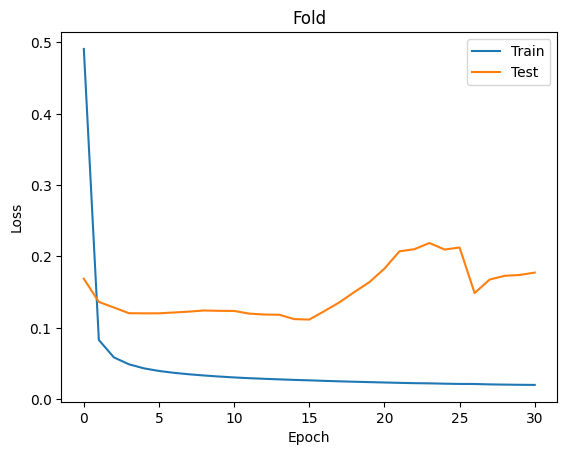

Pamięć wyczyszczona.


--- FOLD 2/5 ---
Tworzenie sampli treningowych...
Tworzenie sampli walidacyjnych...
  Epoch 1/100, Train Loss: 0.4210, Val Loss: 0.5375
  Epoch 2/100, Train Loss: 0.0712, Val Loss: 0.4397
  Epoch 3/100, Train Loss: 0.0496, Val Loss: 0.4577
  Epoch 4/100, Train Loss: 0.0417, Val Loss: 0.4648
  Epoch 5/100, Train Loss: 0.0374, Val Loss: 0.4769
  Epoch 6/100, Train Loss: 0.0344, Val Loss: 0.4942
  Epoch 7/100, Train Loss: 0.0358, Val Loss: 0.5373
  Epoch 8/100, Train Loss: 0.0351, Val Loss: 0.5062
  Epoch 9/100, Train Loss: 0.0312, Val Loss: 0.5117
  Epoch 10/100, Train Loss: 0.0295, Val Loss: 0.5139
  Epoch 11/100, Train Loss: 0.0286, Val Loss: 0.5148
  Epoch 12/100, Train Loss: 0.0278, Val Loss: 0.5192
  Epoch 13/100, Train Loss: 0.0271, Val Loss: 0.5218
  Epoch 14/100, Train Loss: 0.0265, Val Loss: 0.5211
  Epoch 15/100, Train Loss: 0.0258, Val Loss: 0.5239
  Epoch 16/100, Train Loss: 0.0251, Val Loss: 0.5230
  Epoch 17/100, Train Loss: 0.0245, Val Loss: 0.5234
 

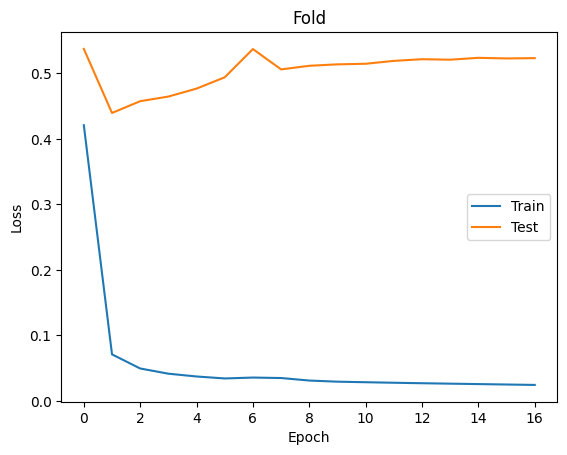

Pamięć wyczyszczona.


--- FOLD 3/5 ---
Tworzenie sampli treningowych...
Tworzenie sampli walidacyjnych...
  Epoch 1/100, Train Loss: 0.4080, Val Loss: 0.1500
  Epoch 2/100, Train Loss: 0.0764, Val Loss: 0.1331
  Epoch 3/100, Train Loss: 0.0523, Val Loss: 0.1326
  Epoch 4/100, Train Loss: 0.0485, Val Loss: 0.1312
  Epoch 5/100, Train Loss: 0.0397, Val Loss: 0.1316
  Epoch 6/100, Train Loss: 0.0366, Val Loss: 0.1291
  Epoch 7/100, Train Loss: 0.0341, Val Loss: 0.1269
  Epoch 8/100, Train Loss: 0.0323, Val Loss: 0.1237
  Epoch 9/100, Train Loss: 0.0308, Val Loss: 0.1227
  Epoch 10/100, Train Loss: 0.0295, Val Loss: 0.1195
  Epoch 11/100, Train Loss: 0.0287, Val Loss: 0.1146
  Epoch 12/100, Train Loss: 0.0274, Val Loss: 0.1107
  Epoch 13/100, Train Loss: 0.0265, Val Loss: 0.1104
  Epoch 14/100, Train Loss: 0.0256, Val Loss: 0.1086
  Epoch 15/100, Train Loss: 0.0247, Val Loss: 0.1079
  Epoch 16/100, Train Loss: 0.0239, Val Loss: 0.1076
  Epoch 17/100, Train Loss: 0.0232, Val Loss: 0.1066
 

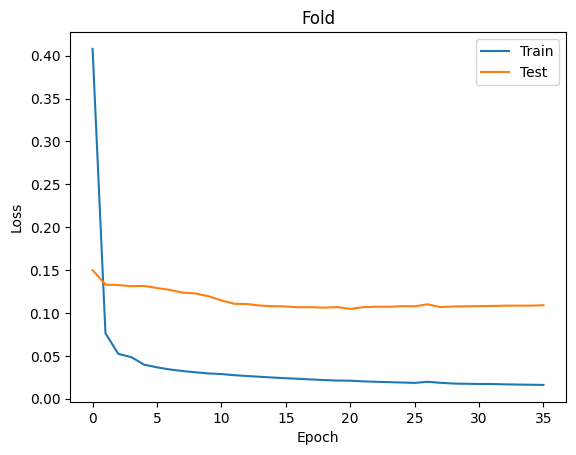

Pamięć wyczyszczona.


--- FOLD 4/5 ---
Tworzenie sampli treningowych...
Tworzenie sampli walidacyjnych...
  Epoch 1/100, Train Loss: 0.4058, Val Loss: 1.3056
  Epoch 2/100, Train Loss: 0.0703, Val Loss: 1.1718
  Epoch 3/100, Train Loss: 0.0474, Val Loss: 1.1220
  Epoch 4/100, Train Loss: 0.0398, Val Loss: 1.1049
  Epoch 5/100, Train Loss: 0.0355, Val Loss: 1.0933
  Epoch 6/100, Train Loss: 0.0325, Val Loss: 1.0904
  Epoch 7/100, Train Loss: 0.0303, Val Loss: 1.0850
  Epoch 8/100, Train Loss: 0.0285, Val Loss: 1.0824
  Epoch 9/100, Train Loss: 0.0271, Val Loss: 1.0821
  Epoch 10/100, Train Loss: 0.0260, Val Loss: 1.0758
  Epoch 11/100, Train Loss: 0.0249, Val Loss: 1.0804
  Epoch 12/100, Train Loss: 0.0240, Val Loss: 1.0780
  Epoch 13/100, Train Loss: 0.0232, Val Loss: 1.0727
  Epoch 14/100, Train Loss: 0.0225, Val Loss: 1.0761
  Epoch 15/100, Train Loss: 0.0219, Val Loss: 1.0746
  Epoch 16/100, Train Loss: 0.0213, Val Loss: 1.0758
  Epoch 17/100, Train Loss: 0.0208, Val Loss: 1.0705
 

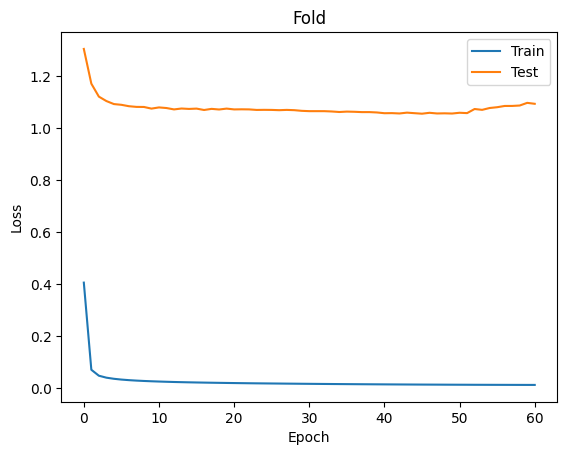

Pamięć wyczyszczona.


--- FOLD 5/5 ---
Tworzenie sampli treningowych...
Tworzenie sampli walidacyjnych...
  Epoch 1/100, Train Loss: 0.4279, Val Loss: 0.4107
  Epoch 2/100, Train Loss: 0.0744, Val Loss: 0.4093
  Epoch 3/100, Train Loss: 0.0536, Val Loss: 0.3820
  Epoch 4/100, Train Loss: 0.0467, Val Loss: 0.3726
  Epoch 5/100, Train Loss: 0.0423, Val Loss: 0.3358
  Epoch 6/100, Train Loss: 0.0376, Val Loss: 0.3040
  Epoch 7/100, Train Loss: 0.0377, Val Loss: 0.2815
  Epoch 8/100, Train Loss: 0.0339, Val Loss: 0.2550
  Epoch 9/100, Train Loss: 0.0324, Val Loss: 0.2453
  Epoch 10/100, Train Loss: 0.0311, Val Loss: 0.2313
  Epoch 11/100, Train Loss: 0.0306, Val Loss: 0.2086
  Epoch 12/100, Train Loss: 0.0293, Val Loss: 0.2168
  Epoch 13/100, Train Loss: 0.0294, Val Loss: 0.2270
  Epoch 14/100, Train Loss: 0.0274, Val Loss: 0.2415
  Epoch 15/100, Train Loss: 0.0264, Val Loss: 0.2394
  Epoch 16/100, Train Loss: 0.0255, Val Loss: 0.2759
  Epoch 17/100, Train Loss: 0.0247, Val Loss: 0.2873
 

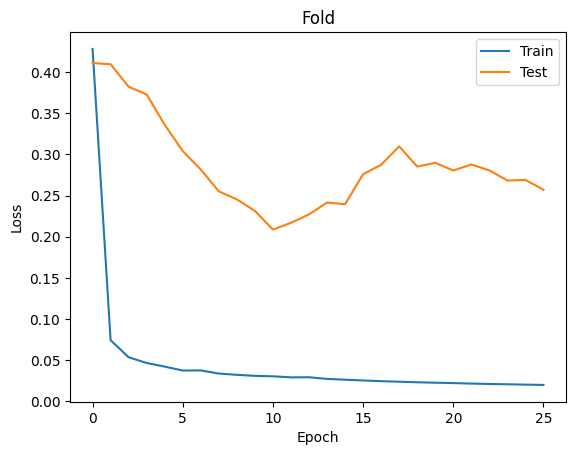

Pamięć wyczyszczona.


--- Eksperyment Zakończony ---
Najlepsze epoki z każdego foldu: [16, 2, 21, 46, 11]
==> Mediana optymalnych epok (Twoja 'Złota Liczba'): 16


In [4]:
data = load_data_from_db()
X, Y = create_x_y(data) # X, Y to LISTY wyścigów

# === 2. Hiperparametry Eksperymentu ===
# Upewnij się, że znasz najkrótszy wyścig (np. 1650)
SEQUENCE_LENGTH = 800
STEP = 1

lr = 1e-4
BATCH_SIZE = 128
num_epochs = 85
weight = [0.8, 1.2, 1.8, 0.2]


MAX_EPOCHS = 100       # Wystarczająco dużo, aby EarlyStopping zadziałał
PATIENCE = 15          # Cierpliwość dla EarlyStopping

DROPOUT_RATE = 0.4     # Z naszej poprzedniej rozmowy

# === 3. Krytyczne Ustawienia Modelu (Na podstawie naszych rozmów) ===
# Zakładam, że Twoje wejście X ma 38 cech (z sin/cos I RaceDIST)
# Zakładam, że Twoje wyjście Y ma 12 cech (z sin/cos, BEZ RaceDIST)
input_size = X_SHAPE
output_size = Y_SHAPE 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")
loss_cont = nn.MSELoss()

# === 4. Pętla Walidacji Krzyżowej (K-Fold) ===
N_SPLITS = 5
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=12343)
all_best_epochs = [] # Tu zbieramy wyniki

print(f"--- Rozpoczynam Eksperyment K-Fold (K={N_SPLITS}) ---")


for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n--- FOLD {fold + 1}/{N_SPLITS} ---")
    val_losses = []
    train_losses = []
    
    # 1. Podział danych na listy wyścigów
    X_train_races = [X[i] for i in train_idx]
    Y_train_races = [Y[i] for i in train_idx]
    X_val_races = [X[i] for i in val_idx]
    Y_val_races = [Y[i] for i in val_idx]

    # 2. Tworzenie skalerów (TYLKO na danych treningowych tego foldu)
    scaler_X_min_max, scaler_X_robust, scaler_Y_min_max, scaler_Y_robust = create_scalers(X_train_races, Y_train_races)

    # 3. Skalowanie obu zbiorów
    X_train_scaled, Y_train_scaled = scale_input(X_train_races, Y_train_races, scaler_X_min_max,scaler_X_robust, scaler_Y_min_max, scaler_Y_robust)
    X_val_scaled, Y_val_scaled     = scale_input(X_val_races, Y_val_races, scaler_X_min_max, scaler_X_robust, scaler_Y_min_max, scaler_Y_robust)
    # 4. Tworzenie okien (sampli)
    print("Tworzenie sampli treningowych...")
    X_train_samples, Y_train_samples = create_sliding_windows(X_train_scaled, Y_train_scaled, SEQUENCE_LENGTH, STEP)
    print("Tworzenie sampli walidacyjnych...")
    X_val_samples, Y_val_samples = create_sliding_windows(X_val_scaled, Y_val_scaled, SEQUENCE_LENGTH, STEP)
    
    if len(X_val_samples) == 0:
        print(f"BŁĄD: Fold {fold+1} nie ma danych walidacyjnych. Prawdopodobnie seq_length jest za duży.")
        continue

    # 5. Tworzenie Tensorów i DataLoaderów
    X_train_tensor = torch.tensor(X_train_samples, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train_samples, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_samples, dtype=torch.float32)
    Y_val_tensor = torch.tensor(Y_val_samples, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # 6. Inicjalizacja modelu i optimizera (OD NOWA dla każdego foldu)
    model = LSTMStatePredictor(
        input_size=input_size, 
        hidden_size=256, 
        output_size=output_size, 
        num_layers=1,
        dropout_prob=0.3
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5)

    # 7. Zmienne do EarlyStopping
    best_val_loss = float('inf')
    best_epoch_this_fold = 0
    epochs_no_improve = 0

    # === 5. Wewnętrzna pętla treningu (Epoch) ===
    for epoch in range(MAX_EPOCHS):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred, _ = model(x_batch.to(device))
            
            y_batch = y_batch.to(device)

            loss_progress = loss_cont(y_pred[:, :, 0:2], y_batch[:, :, 0:2])
            loss_fuel     = loss_cont(y_pred[:, :, 2:3], y_batch[:, :, 2:3])
            loss_wear     = loss_cont(y_pred[:, :, 3:7], y_batch[:, :, 3:7])
            loss_temp     = loss_cont(y_pred[:, :, 7:11], y_batch[:, :, 7:11])
            
            
            # Sumujemy straty (tak jak miałeś)
            loss = (weight[0] * loss_progress + 
                    weight[1] * loss_fuel + 
                    weight[2] * loss_wear + 
                    weight[3] * loss_temp 
                    )
            
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        # === 6. Pętla Walidacyjna (NOWA) ===
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                y_pred, _ = model(x_batch.to(device))

                y_batch = y_batch.to(device)

                loss_progress = loss_cont(y_pred[:, :, 0:2], y_batch[:, :, 0:2])
                loss_fuel     = loss_cont(y_pred[:, :, 2:3], y_batch[:, :, 2:3])
                loss_wear     = loss_cont(y_pred[:, :, 3:7], y_batch[:, :, 3:7])
                loss_temp     = loss_cont(y_pred[:, :, 7:11], y_batch[:, :, 7:11])
                
            
                # Sumujemy straty (tak jak miałeś)
                val_loss = (weight[0] * loss_progress + 
                        weight[1] * loss_fuel + 
                        weight[2] * loss_wear + 
                        weight[3] * loss_temp )
                total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        val_losses.append(avg_val_loss)
        train_losses.append(avg_train_loss)
        
        # === 7. Logika Schedulera i EarlyStopping ===
        scheduler.step(avg_val_loss) # <-- Użyj avg_val_loss

        
        print(f"  Epoch {epoch+1}/{MAX_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch_this_fold = epoch + 1
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= PATIENCE:
            print(f"  Early stopping w epoce {epoch + 1}.")
            break
            
    print(f"Fold {fold + 1}: Najlepszy wynik w epoce {best_epoch_this_fold} (Val Loss: {best_val_loss:.4f})")
    all_best_epochs.append(best_epoch_this_fold)

    plt.figure()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Test')
    plt.title(f'Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    del model
    del optimizer
    del X_train_samples, Y_train_samples
    del X_val_samples, Y_val_samples
    del train_dataset, val_dataset
    del train_loader, val_loader
    
    # 2. Wymuś zwolnienie pamięci RAM
    gc.collect()
    
    # 3. Wymuś zwolnienie pamięci VRAM (GPU)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    print("Pamięć wyczyszczona.\n")

# === 8. Obliczenie Mediany (Po wszystkich foldach) ===
if all_best_epochs:
    FINAL_EPOCH_NUMBER = int(np.median(all_best_epochs))
    print(f"\n--- Eksperyment Zakończony ---")
    print(f"Najlepsze epoki z każdego foldu: {all_best_epochs}")
    print(f"==> Mediana optymalnych epok (Twoja 'Złota Liczba'): {FINAL_EPOCH_NUMBER}")
else:
    print("\n--- Eksperyment NIE POWIÓDŁ SIĘ ---")
    print("Nie zebrano żadnych wyników. Sprawdź, czy 'create_sliding_windows' zwraca dane walidacyjne.")